In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import string
import re
from unicodedata import normalize
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed,Bidirectional,GRU
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from keras.layers import Dropout


def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [ ]:
# How many sentences will be used
# Limit the sentences to 10.000 on Kaggle to avoid exceding the
# available RAM space
# Build a generator to avoid this issue

total_sentences = 85221

# Load the dataset
dataset = pd.read_excel("/content/drive/MyDrive/FYP/data.xlsx", nrows = total_sentences)


# What proportion of the sentences will be used for the test set
test_proportion = 0.3
train_test_threshold = int( (1-test_proportion) * total_sentences)

printmd(f'## {total_sentences} "parallel sentences" will be loaded (original sentence + its translation)')
printmd(f'## {train_test_threshold} "parallel sentences" will be used to train the model')
printmd(f'## {total_sentences-train_test_threshold} "parallel sentences" will be used to test the model')

## 85221 "parallel sentences" will be loaded (original sentence + its translation)

## 59654 "parallel sentences" will be used to train the model

## 25567 "parallel sentences" will be used to test the model

In [ ]:
# Shuffle the dataset
dataset = dataset.sample(frac=1, random_state=0)
dataset.iloc[1000:1010]

,English,PSL
42870,The chief was deciding to be a good man.,Was The chief be a good man decides to now.
3261,I have an orange and an apple.,I an orange an apple have.
73922,I had hoped to meet her there.,was I there her meet hope full.
84184,I know that Shazim is agnostic.,I know that Shazim agnostic.
79760,He is a director and should be treated as such.,He director such treat.
61886,I can not believe Anees said yes.,I believe not was Anees say.
65728,Waasif did not follow the rules.,was Waasif rules follow not.
36340,It sounds very strange to me.,It me very strange sounds.
4064,Balam took off his belt.,was Balam his belt take off.
24879,We have just got to keep going.,We just go keep get full.


In [ ]:
def clean(string):
    # Clean the string
    string = string.replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()
    
    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")
        
        
    string = re.sub('\s+',' ', string)
    string = string.strip()
           
    return string

# Clean the sentences
dataset["English"] = dataset["English"].apply(lambda x: clean(x))
dataset["PSL"] = dataset["PSL"].apply(lambda x: clean(x))

# Select one part of the dataset
dataset = dataset.values
dataset = dataset[:total_sentences]

# split into train/test
train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str = "PSL", "English"

# The index in the numpy array of the source and of the target
idx_src, idx_tar = 1,0

In [ ]:
def create_tokenizer(lines):
    # fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
def max_len(lines):
    # max sentence length
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X
 
def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# Prepare target tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')
 



Target (English) Vocabulary Size: 9256

Target (English) Max Length: 12


Source (PSL) Vocabulary Size: 8089

Source (PSL) Max Length: 14


# Glove

In [ ]:
# load embeding for text file
embeddings_index = dict()
f = open('/content/drive/MyDrive/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
dims=300
flag=1
word_index = {w: i for i, w in enumerate(embeddings_index, 1)}
embedding_matrix = np.zeros((len(word_index)+1, dims))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[:dims]
        

In [ ]:
# Prepare training data
trainX = encode_sequences(src_tokenizer, src_length, train[8000:16000, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[8000:16000, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)


In [ ]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    # Create the model
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=src_timesteps,trainable=False))
    model.add(Bidirectional(GRU(n_units)))
    model.add(RepeatVector(tar_timesteps))
    model.add(Dropout(0.1))
    model.add(Bidirectional(GRU(n_units, return_sequences=True)))

    model.add(TimeDistributed(Dense(tar_vocab, activation='sigmoid')))
    return model
 

In [ ]:
# Create model
model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
history = model.fit(trainX, 
          trainY, 
          epochs=100, 
          batch_size=128, 
          validation_split=0.2, 
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )
            ])

Epoch 1/100
50/50 [==============================] - 14s 145ms/step - loss: 1.6793 - val_loss: 1.5742
Epoch 2/100
50/50 [==============================] - 5s 98ms/step - loss: 1.3189 - val_loss: 1.4893
Epoch 3/100
50/50 [==============================] - 5s 102ms/step - loss: 1.0901 - val_loss: 1.4483
Epoch 4/100
50/50 [==============================] - 5s 105ms/step - loss: 0.9318 - val_loss: 1.4185
Epoch 5/100
50/50 [==============================] - 5s 101ms/step - loss: 0.8007 - val_loss: 1.3941
Epoch 6/100
50/50 [==============================] - 5s 103ms/step - loss: 0.7005 - val_loss: 1.4027
Epoch 7/100
50/50 [==============================] - 5s 103ms/step - loss: 0.6272 - val_loss: 1.3868
Epoch 8/100
50/50 [==============================] - 5s 104ms/step - loss: 0.5605 - val_loss: 1.3939
Epoch 9/100
50/50 [==============================] - 5s 103ms/step - loss: 0.5057 - val_loss: 1.3757
Epoch 10/100
50/50 [==============================] - 5s 101ms/step - loss: 0.4598 - val_lo

In [ ]:
model.save('/content/drive/MyDrive/FYP/GRU Golvee Model/bigrumodel.h5')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/FYP/GRU Golvee Model/bigrumodel.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 300)           120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               857088    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 12, 512)           0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 12, 512)           1182720   
_________________________________________________________________
time_distributed (TimeDistri (None, 12, 9256)          4748328   
Total params: 126,788,436
Trainable params: 6,788,136
Non-trainable params: 120,000,300
__________________________________

# Testing Phase with Golvee

In [ ]:
# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[20000:25567, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[20000:25567, idx_tar])
testY = encode_output(testY, tar_vocab_size)

In [ ]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break
 
# test on some training sequences
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX,test[:10000,:])



### Result on the Test Set ###
PSL (SOURCE)                   ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

was she food cook full         she had cooked food       she had cooked food
was i them tell not            i did not tell them       i did not tell them
i stupid feel                  i feel stupid             i feel stupid
ranjhoo it like after          ranjhoo will like it      ranjhoo will like it
was they their parents obey not they did not obey their parents they did not carry their bag
hello                          hello                     hello
i brothers sisters have        i have eight brothers and sisters i have brothers brothers
i now go go now                i am going to go now      i am going to go now
i join in yes no               can i join in             can i join in
was it important               it was important          it was important
you mail full                  you have mail             you have girl
everybody know i you hate      ev

## Bleu Score

In [ ]:
def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

# Compute the BLEU Score
# bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(model, tar_tokenizer, testX, test[:10000,:])

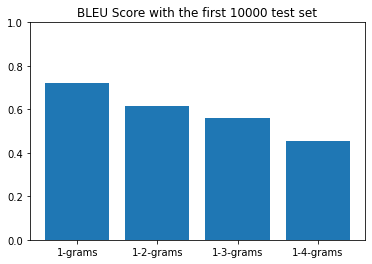

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the first 10000 test set")
plt.ylim((0,1))
plt.show()

In [ ]:
print(bleu_test)

{'1-grams': 0.7232302157936887, '1-2-grams': 0.6150046669667623, '1-3-grams': 0.5613931268421277, '1-4-grams': 0.4530424787595973}


## WER

In [ ]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    #print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        #print(f'{raw_src:30} {raw_target:25} {translation}')
        #print(translation)     #predicit
        #print(raw_target)      #actual
        actual.append(raw_target)
        predicted.append(translation)
        if i >= limit: # Display some of the result
            return actual,predicted
            break
 
# # test on some training sequences!pip install jiwer
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
Actual,Predicted=compare_prediction(model, tar_tokenizer, testX,test[:10000,:])



### Result on the Test Set ###


In [ ]:
!pip install jiwer

     |████████████████████████████████| 50 kB 3.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149862 sha256=65fb5406b855f3b478f2f35e54d807bd722bb0d71f97977f08cfa058cdd00e3d
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
from jiwer import wer
error=wer(Actual,Predicted)
error

0.15463917525773196

## TER

In [ ]:
!pip install pyter3
import pyter

In [ ]:
i=0
sum=0
while i<len(Actual):
  #print(pyter.ter(Actual[i].split(),Predicted[i].split()))
  sum+=pyter.ter(Actual[i].split(),Predicted[i].split())
  i=i+1



sum=sum/len(Actual)
sum

0.1619047619047619

# For 2nd 10000 testing Instance.

In [ ]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break
 
# test on some training sequences
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test[10000:20000,:])



### Result on the Test Set ###
PSL (SOURCE)                   ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

was salman quite frustrate     salman was quite frustrated salman was quite quite
was nihal his new guitar show  nihal showed me his new guitar nihal showed his his his
sajeel other week here come    sajeel comes here every other week sajeel comes here here week week
was i direction change         i changed direction       i was the change
i glad that was ranjhoo win    i am glad that ranjhoo won i am glad glad won won
i do after whatever you want   i will do whatever you want i will do whatever whatever want
i know when hassam lie now     i know when hassam is lying i know when when is lying
he his own way live wish       he wishes to live his own way he lives to own his own
manan his wife karachi live    manan and his wife live in karachi manan karachi karachi karachi karachi karachi
was he home come evening yes no did he come home in the evening did he come hom

## Bleu Score

In [ ]:
def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

# Compute the BLEU Score
# bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(model, tar_tokenizer, testX, test[10000:20000,:])

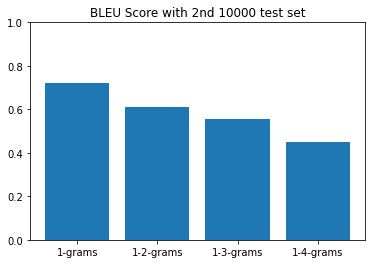

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with 2nd 10000 test set")
plt.ylim((0,1))
plt.show()

In [ ]:
print(bleu_test)

{'1-grams': 0.7206259512603983, '1-2-grams': 0.6112569202502609, '1-3-grams': 0.5575986997719323, '1-4-grams': 0.4486377701583157}


## WER

In [ ]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    #print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        #print(f'{raw_src:30} {raw_target:25} {translation}')
        #print(translation)     #predicit
        #print(raw_target)      #actual
        actual.append(raw_target)
        predicted.append(translation)
        if i >= limit: # Display some of the result
            return actual,predicted
            break
 
# # test on some training sequences!pip install jiwer
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
Actual,Predicted=compare_prediction(model, tar_tokenizer, testX, test[10000:20000,:])



### Result on the Test Set ###


In [ ]:
!pip install jiwer

     |████████████████████████████████| 50 kB 4.2 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149866 sha256=15d8f0aab6f9267d1844ae8d52fdc7156f136c199299e4da4d5a6a390aad0a78
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
from jiwer import wer
error=wer(Actual,Predicted)
error

0.38016528925619836

## TER

In [ ]:
!pip install pyter3
import pyter

In [ ]:
i=0
sum=0
while i<len(Actual):
  #print(pyter.ter(Actual[i].split(),Predicted[i].split()))
  sum+=pyter.ter(Actual[i].split(),Predicted[i].split())
  i=i+1



sum=sum/len(Actual)
sum

0.40249433106575966

# For Last 5567 testing Instance.   

In [ ]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break
 
# test on some training sequences
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test[20000:25567,:])



### Result on the Test Set ###
PSL (SOURCE)                   ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

they old woman help now not    they are not helping old woman they are not helping old woman
was we chances had             we had the chances        we had a
ashraf say i too nosey         ashraf says i am too nosey ashraf says i is too young
i it much think full not       i haven t thought much about it i haven t thought it about it
was i zabhi my room show       i showed my room to zabhi i showed her way way way
was fight long last not        the fight did not last long nabi did not last the last
i think was abbas my help want i think abbas wanted my help i think you want to help brother
was it real scary              it was real scary         it was a red
i small towns like             i like small towns        i like a reliable
was i uniform wear now not     i was not wearing a uniform i was not wearing a
mahi good captain              mahi is a good captain 

## Bleu Score

In [ ]:
def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

# Compute the BLEU Score
# bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(model, tar_tokenizer, testX,test[20000:25567,:])

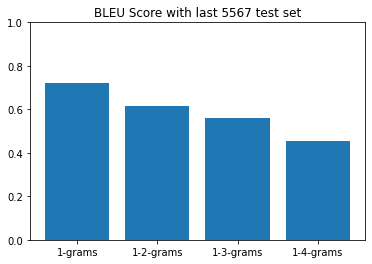

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with last 5567 test set")
plt.ylim((0,1))
plt.show()

In [ ]:
print(bleu_test)

{'1-grams': 0.7229104729701122, '1-2-grams': 0.6135062645591065, '1-3-grams': 0.559877004472567, '1-4-grams': 0.45247480876121837}


## WER

In [ ]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    #print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        #print(f'{raw_src:30} {raw_target:25} {translation}')
        #print(translation)     #predicit
        #print(raw_target)      #actual
        actual.append(raw_target)
        predicted.append(translation)
        if i >= limit: # Display some of the result
            return actual,predicted
            break
 
# # test on some training sequences!pip install jiwer
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
Actual,Predicted=compare_prediction(model, tar_tokenizer, testX, test[20000:25567,:])



### Result on the Test Set ###


In [ ]:
!pip install jiwer

     |████████████████████████████████| 50 kB 3.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149874 sha256=e8117225075cad45bdb383e15cc243af586fadf82f304ab0604324617eca6294
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
from jiwer import wer
error=wer(Actual,Predicted)
error

0.3220338983050847

## TER

In [ ]:
!pip install pyter3
import pyter

In [ ]:
i=0
sum=0
while i<len(Actual):
  #print(pyter.ter(Actual[i].split(),Predicted[i].split()))
  sum+=pyter.ter(Actual[i].split(),Predicted[i].split())
  i=i+1



sum=sum/len(Actual)
sum

0.32573696145124714

# Average WER

In [ ]:
(0.154+0.380+0.322)/3

0.2853333333333334

# Average TER

In [ ]:
(0.161+0.402+0.325)/3

0.29600000000000004

In [ ]:
gram1=(0.723+0.720+0.722)/3
gram2=(0.615+0.611+0.613)/3
gram3=(0.561+0.557+0.559)/3
gram4=(0.453+0.448+0.452)/3

In [ ]:
bleu_dic = {}
bleu_dic['1-grams']=gram1
bleu_dic['1-2-grams']= gram2
bleu_dic['1-3-grams']=gram3
bleu_dic['1-4-grams']=gram4

In [ ]:
print(bleu_dic)

{'1-grams': 0.7216666666666667, '1-2-grams': 0.613, '1-3-grams': 0.559, '1-4-grams': 0.451}


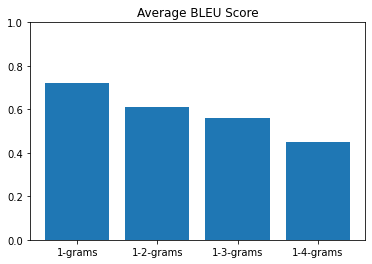

In [ ]:
plt.bar(x = bleu_dic.keys(), height = bleu_dic.values())
plt.title("Average BLEU Score")
plt.ylim((0,1))
plt.show()